### Sequence to Sequence model using MLP network and keras

In [26]:
from random import randint, seed
from tensorflow.keras import models
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

#### Creating a dataset
eg:
- input = [3,2,3,0]
- output = [0,3,2,3]

after one-hot-encoding, input will be:
- [[0,0,0,1,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0]
]

#### Explaining the variables

n_unique = 10
- explanation:
there are 9 possible integers so after one hot encoding the 
max value: [0,0,0,0,0,0,0,0,0,1] = 9

A sequence is the each individual input going into the mode
- eg: [3,2,3,0]


In [48]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	
	return [randint(0, n_unique-1) for _ in range(length)]

In [49]:
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

In [50]:
# decode a one hot encoded string
# For example:
# Input: [[0, 1, 0], [1, 0, 0], [0, 0, 1]]
# Output: [1, 0, 2]
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

In [51]:
# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nSample X and y')
		print('\nIn raw format:')
		print('X[0]=%s, y[0]=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
		print('\nIn one_hot_encoded format:')
		print('X[0]=%s' % (X[0]))
		print('y[0]=%s' % (y[0]))
	return X,y

In [52]:
def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

#### Function to train and test the mode (Early stopping monitor - val_loss)

In [53]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	
               y_test, epochs=500, verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', 
	                   mode='min', verbose=1, patience=20)
	# train model
	print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

	# spot check some examples
	print('some examples...')
	for _ in range(10):
		X,y = get_reversed_pairs(n_timesteps_in, n_features)
		yhat = model.predict(X, verbose=0)
		print('Input',one_hot_decode(X[0]),
					'Expected:', one_hot_decode(y[0]), 
						'Predicted', one_hot_decode(yhat[0]),
							'', np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )
	


In [56]:
#@title Configure problem

n_timesteps_in =   4#@param {type:"integer"}
#each input sample has 4 values

n_features = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1
#n_timesteps_out = 2  #@param {type:"integer"}
#each output sample has 2 values padded with 0

# generate random sequence
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 20000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)




Sample X and y

In raw format:
X[0]=[6, 3, 0, 3], y[0]=[3, 0, 3, 6]

In one_hot_encoded format:
X[0]=[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
y[0]=[[0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]

Generated sequence datasets as follows
X_train.shape:  (20000, 4, 10) y_train.shape:  (20000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


### Developing an MLP model for fixed size and same-data type input and output sequences

In [62]:
#@title Multi-Layer Perceptron network
numberOfPerceptrons=64
model_Multi_Layer_Perceptron = Sequential(name='model_Multi_Layer_Perceptron')
model_Multi_Layer_Perceptron.add(Input(shape=(n_timesteps_in, n_features)))
model_Multi_Layer_Perceptron.add(Dense(4*numberOfPerceptrons, activation='relu'))
model_Multi_Layer_Perceptron.add(Dense(2*numberOfPerceptrons, activation='relu'))
model_Multi_Layer_Perceptron.add(Dense(numberOfPerceptrons, activation='relu'))
model_Multi_Layer_Perceptron.add(Dense(n_features, activation='softmax'))

model_Multi_Layer_Perceptron.compile(loss='categorical_crossentropy',
                                     optimizer=Adam(learning_rate=0.001), 
                                    metrics=['accuracy'])
model_Multi_Layer_Perceptron.summary()
#plot_model(model_Multi_Layer_Perceptron,show_shapes=True)

Model: "model_Multi_Layer_Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 4, 256)            2816      
_________________________________________________________________
dense_45 (Dense)             (None, 4, 128)            32896     
_________________________________________________________________
dense_46 (Dense)             (None, 4, 64)             8256      
_________________________________________________________________
dense_47 (Dense)             (None, 4, 10)             650       
Total params: 44,618
Trainable params: 44,618
Non-trainable params: 0
_________________________________________________________________


### Training and testing

In [66]:
one_hot_decode(X_train[0])

[5, 8, 3, 4]

In [67]:
one_hot_decode(y_train[0])

[4, 3, 8, 5]

training for  500  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 2s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 2/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 3/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 4/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 5/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 6/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 7/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 8/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 9/500
563/563 - 1s - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.0972
Epoch 10/500
563/563 - 1s - loss:

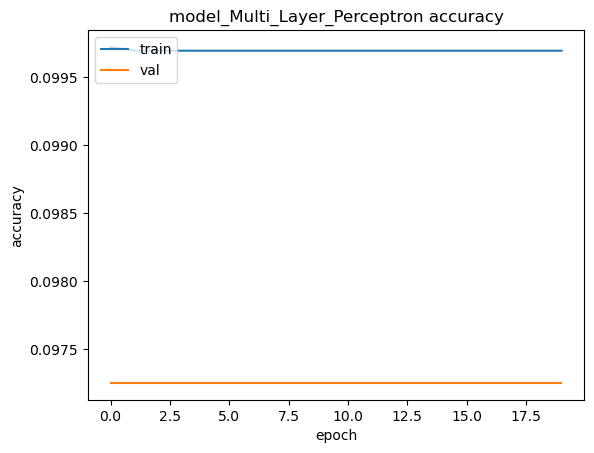

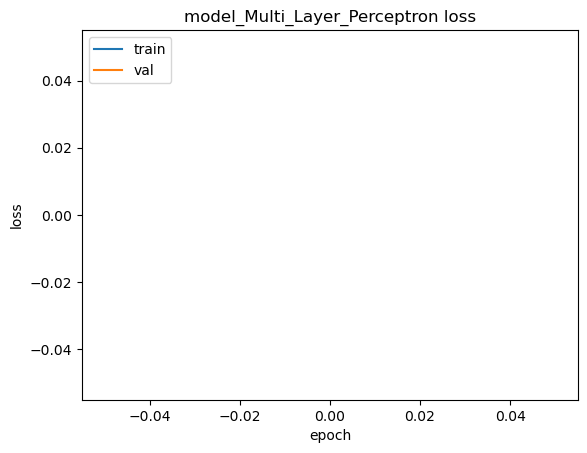

some examples...
Input [6, 0, 3, 9] Expected: [9, 3, 0, 6] Predicted [0, 0, 0, 0]  False
Input [3, 9, 7, 9] Expected: [9, 7, 9, 3] Predicted [0, 0, 0, 0]  False
Input [3, 7, 8, 9] Expected: [9, 8, 7, 3] Predicted [0, 0, 0, 0]  False
Input [0, 9, 5, 3] Expected: [3, 5, 9, 0] Predicted [0, 0, 0, 0]  False
Input [5, 6, 0, 0] Expected: [0, 0, 6, 5] Predicted [0, 0, 0, 0]  False
Input [7, 2, 6, 6] Expected: [6, 6, 2, 7] Predicted [0, 0, 0, 0]  False
Input [7, 5, 7, 2] Expected: [2, 7, 5, 7] Predicted [0, 0, 0, 0]  False
Input [2, 4, 9, 6] Expected: [6, 9, 4, 2] Predicted [0, 0, 0, 0]  False
Input [3, 3, 9, 9] Expected: [9, 9, 3, 3] Predicted [0, 0, 0, 0]  False
Input [5, 1, 1, 2] Expected: [2, 1, 1, 5] Predicted [0, 0, 0, 0]  False


In [63]:
train_test(model_Multi_Layer_Perceptron, X_train, y_train , X_test, y_test, verbose=2)

#### We observed that the model does not perform well as the accuracy and loss is only around 10%